In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from seaborn import heatmap

In [2]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')

bidsroot = os.path.join(project_dir, 'data_denoised')
deriv_dir = os.path.join(bidsroot, 'derivatives')
fmriprep_dir = os.path.join(deriv_dir, 'denoised_fmriprep-22.1.1')

beh_out_dir = os.path.join(deriv_dir, 'behavior')

task_list = ['tonecat']
task_label = task_list[0]

In [3]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27', # did not run functional MRI
               'sub-FLT07', # bad QA 11/14/23
               #'sub-FLT02', # missing resp_6 in run00 (pressing wrong keys)
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [4]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])
sub_dict = {'Mandarin': sub_list_mand, 'non-Mandarin': sub_list_nman}
sub_list_all = sub_list_mand + sub_list_nman

In [5]:
tone_labels = ['T1', 'T2', 'T3', 'T4']

# Accuracy and reaction time

In [6]:
run_acc_dict = {}
run_rt_dict = {}

run_df_list = []
for rx, run in enumerate(range(6)):
    group_acc_list = []
    group_rt_list = []
    
    group_resp1_list = []
    group_resp2_list = []
    group_resp3_list = []
    group_resp4_list = []
    
    sub_list = []
    for sub_id in sub_list_nman:
        sub_list.append(sub_id)
        bids_dir = os.path.join(bidsroot, sub_id, 'func')

        #bids_tsv_list = sorted(glob(bids_dir+f'/*task-{task_label}*events.tsv'))

        run_tsv = glob(bids_dir+f'/*task-{task_label}_run-0{rx+1}*events.tsv')[0]
        tsv_pd = pd.read_csv(run_tsv, sep='\t')

        tsv_pd = tsv_pd[~tsv_pd['trial_type'].str.contains('resp_None')]


        simple_df = tsv_pd.loc[:,['trial_type', 'correct_key', 'response_time']].dropna()
        
        # simple_df = simple_df[~tsv_pd['trial_type'].str.contains('resp_8')]

        simple_df['correct_key'] = simple_df['correct_key'].astype(int).astype(str)

        simple_df['trial_type'] = [x[-1] for x in simple_df['trial_type']]

        renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                        ['1', '2', '3', '4'])

        run_rt = renum_simple_df.response_time.astype(float).mean()
        #print(run_rt)

        ncor = len(renum_simple_df.query('trial_type == correct_key'))
        ninc = len(renum_simple_df.query('trial_type != correct_key'))
        ntrials = ncor+ninc

        run_acc = ncor / ntrials
        #print(run_acc)
        
        group_acc_list.append(run_acc)
        group_rt_list.append(run_rt)
        
        # get response counts
        group_resp1_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['1'])
        try:
            group_resp2_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['2'])
        except:
            group_resp2_list.append([0])
        group_resp3_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['3'])
        group_resp4_list.append(renum_simple_df.groupby('trial_type')['response_time'].count().loc['4'])
    
    # older approach
    #run_acc_dict[f'run-0{rx+1}'] = group_acc_list
    #run_rt_dict[f'run-0{rx+1}'] = group_rt_list    
    
    # combine results and info into run-specific dataframe
    run_df = pd.DataFrame(columns=['Participant_ID', 'Run', 'Accuracy', 'RT (s)'])
    run_df['Participant_ID'] = sub_list
    run_df['Run'] = f'run-0{rx+1}'
    run_df['Accuracy'] = group_acc_list
    run_df['RT (s)'] = group_rt_list
    
    # add response summaries to dataframe
    run_df['count_resp-1'] = group_resp1_list
    run_df['count_resp-2'] = group_resp2_list
    run_df['count_resp-3'] = group_resp3_list
    run_df['count_resp-4'] = group_resp4_list
    
    resp_df = pd.DataFrame()
    for resp in ['1', '2', '3', '4']:
        resp_df[f'resp-{resp}'] = renum_simple_df.groupby('trial_type')['response_time'].count().loc[str(resp)]
    
    # append to list of dataframes across runs
    run_df_list.append(run_df)

In [7]:
run_df

,Participant_ID,Run,Accuracy,RT (s),count_resp-1,count_resp-2,count_resp-3,count_resp-4
0,sub-FLT02,run-06,0.893617,1.021135,12,12,11,12
1,sub-FLT04,run-06,0.729167,1.300266,19,8,14,7
2,sub-FLT06,run-06,0.895833,1.036703,12,13,9,14
3,sub-FLT09,run-06,0.812500,1.099691,16,11,11,10
4,sub-FLT11,run-06,0.872340,1.013764,9,11,11,16
5,sub-FLT12,run-06,0.936170,1.116703,12,12,11,12
6,sub-FLT13,run-06,0.893617,1.087650,13,12,9,13
7,sub-FLT14,run-06,0.979167,1.035730,12,13,11,12
8,sub-FLT20,run-06,0.847826,1.093342,15,12,11,8
9,sub-FLT25,run-06,0.347826,1.242382,6,22,9,9


In [8]:
behav_df = pd.concat(run_df_list)

In [9]:
# save behavioral summary file
fname = 'FLT_behav_summary.csv'
behav_df.to_csv(fname)

## Statistics

In [10]:
from scipy import stats

### ANOVA statistics

In [11]:
import pingouin as pg
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp, ttest_rel

#### Merge runs into early, middle, and final learning stages

In [12]:
run_to_stage = {
    'run-01': 'early',
    'run-02': 'early',
    'run-03': 'middle',
    'run-04': 'middle',
    'run-05': 'final',
    'run-06': 'final', }

behav_df['Learning_Stage'] = behav_df['Run'].map(run_to_stage)

# Define the custom order as a list
category_order = ['early', 'middle', 'final']

# Convert the 'Category' column to a Categorical type with the specified order
behav_df['Learning_Stage'] = pd.Categorical(behav_df['Learning_Stage'], categories=category_order, ordered=True)

# Sort the DataFrame by the Categorical column
behav_df = behav_df.sort_values(by='Learning_Stage')

stage_df = behav_df.groupby(['Participant_ID', 'Learning_Stage']).agg({
    'Accuracy': 'mean',
    'RT (s)': 'mean',
    #'count_resp-1': 'sum',
    #'count_resp-2': 'sum',
    #'count_resp-3': 'sum',
    #'count_resp-4': 'sum',
}).reset_index()


/scratch/slurm-7007573/ipykernel_3493173/1309997270.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_df = behav_df.groupby(['Participant_ID', 'Learning_Stage']).agg({


In [13]:
stage_df.dtypes

Participant_ID      object
Learning_Stage    category
Accuracy           float64
RT (s)             float64
dtype: object

In [14]:
stage_df.head()

,Participant_ID,Learning_Stage,Accuracy,RT (s)
0,sub-FLT02,early,0.596899,1.566697
1,sub-FLT02,middle,0.850423,1.104186
2,sub-FLT02,final,0.904255,1.033077
3,sub-FLT04,early,0.416667,1.305031
4,sub-FLT04,middle,0.627660,1.277885


In [15]:
stage_df.groupby(['Learning_Stage']).agg({
    'Accuracy': 'mean',
    'RT (s)': 'mean',
    #'count_resp-1': 'sum',
    #'count_resp-2': 'sum',
    #'count_resp-3': 'sum',
    #'count_resp-4': 'sum',
}).reset_index()

/scratch/slurm-7007573/ipykernel_3493173/3322860759.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_df.groupby(['Learning_Stage']).agg({


,Learning_Stage,Accuracy,RT (s)
0,early,0.507859,1.213296
1,middle,0.736716,1.147727
2,final,0.802171,1.117000


In [16]:
stage_df.groupby(['Participant_ID']).agg({
    'Accuracy': 'mean',
    'RT (s)': 'mean',
    #'count_resp-1': 'sum',
    #'count_resp-2': 'sum',
    #'count_resp-3': 'sum',
    #'count_resp-4': 'sum',
}).reset_index()

,Participant_ID,Accuracy,RT (s)
0,sub-FLT02,0.783859,1.234653
1,sub-FLT04,0.568927,1.292307
2,sub-FLT06,0.619517,1.087644
3,sub-FLT09,0.702034,1.120832
4,sub-FLT11,0.650594,1.085482
5,sub-FLT12,0.907920,1.113409
6,sub-FLT13,0.606537,1.083879
7,sub-FLT14,0.909058,1.099235
8,sub-FLT20,0.810091,1.108121
9,sub-FLT25,0.327262,1.248050


In [17]:
accuracy_range = stage_df.groupby('Learning_Stage')['Accuracy'].agg(['min', 'max', 'mean', 'std'])
accuracy_range['range'] = accuracy_range['max'] - accuracy_range['min']
accuracy_range


/scratch/slurm-7007573/ipykernel_3493173/4271175138.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_range = stage_df.groupby('Learning_Stage')['Accuracy'].agg(['min', 'max', 'mean', 'std'])


,min,max,mean,std,range
Learning_Stage,,,,,
early,0.290527,0.892199,0.507859,0.184037,0.601672
middle,0.397780,0.968528,0.736716,0.186977,0.570749
final,0.293478,0.979167,0.802171,0.197145,0.685688


#### Accuracy

In [18]:
# First, find the difference between models in the main dataframe
pairwise_acc = pg.pairwise_tests(data=stage_df,
                             dv='Accuracy', 
                             within=['Learning_Stage'],
                             subject='Participant_ID',
                             padjust='fdr',
                             return_desc=True) 

# Check available columns
print("Available columns:", pairwise_acc.columns)

# Display key columns 
print("\nPost-hoc Pairwise Comparisons:")

pd.set_option('display.max_rows', None)

# show results
pairwise_acc[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]
#print(pairwise_interaction)

Available columns: Index(['Contrast', 'A', 'B', 'mean(A)', 'std(A)', 'mean(B)', 'std(B)',
       'Paired', 'Parametric', 'T', 'dof', 'alternative', 'p-unc', 'p-corr',
       'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,Contrast,A,B,T,dof,p-unc,p-corr,BF10
0,Learning_Stage,Learning_Stage,early,middle,-6.289050,11.0,0.000059,0.000178,454.279
1,Learning_Stage,Learning_Stage,early,final,-5.573663,11.0,0.000167,0.000250,185.331
2,Learning_Stage,Learning_Stage,middle,final,-1.813359,11.0,0.097124,0.097124,1.01


In [19]:
pairwise_acc

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Learning_Stage,early,middle,0.507859,0.184037,0.736716,0.186977,True,True,-6.289050,11.0,two-sided,0.000059,0.000178,fdr,454.279,-1.191106
1,Learning_Stage,early,final,0.507859,0.184037,0.802171,0.197145,True,True,-5.573663,11.0,two-sided,0.000167,0.000250,fdr,185.331,-1.490080
2,Learning_Stage,middle,final,0.736716,0.186977,0.802171,0.197145,True,True,-1.813359,11.0,two-sided,0.097124,0.097124,fdr,1.01,-0.328939


In [20]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(stage_df, 
              aggregate_func='mean',
              depvar='Accuracy', 
              subject='Participant_ID', 
              within=['Learning_Stage']).fit()

# Display results
aov.summary()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


,F Value,Num DF,Den DF,Pr > F
Learning_Stage,26.4577,2.0000,22.0000,0.0000


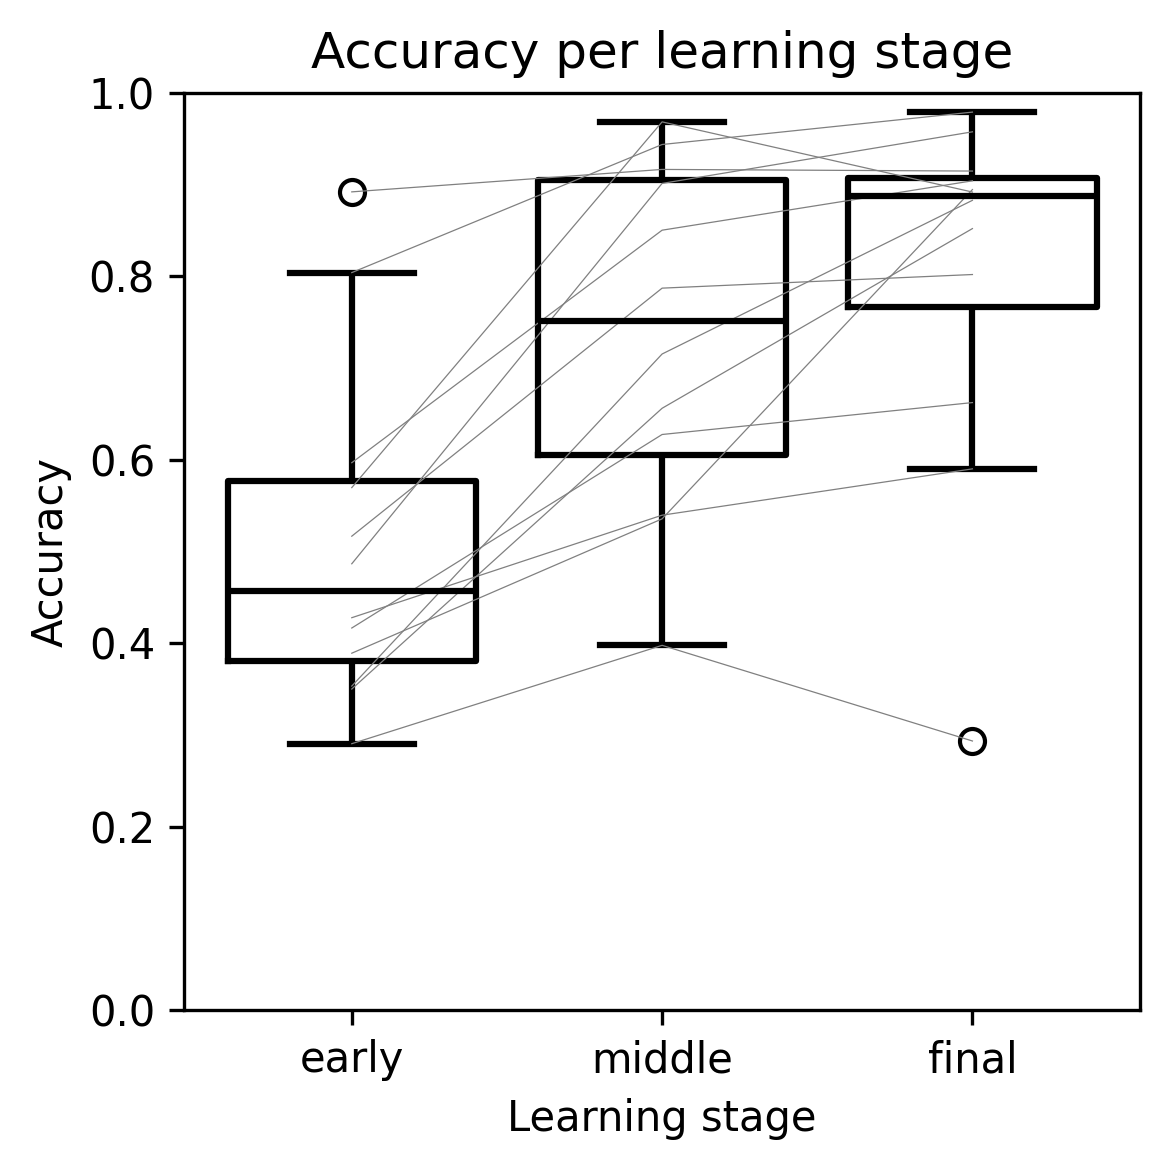

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)
'''sns.lineplot(stage_df, x='Learning_Stage', y='Accuracy', 
             color='black', err_style='bars', 
             ax=ax)
'''
sns.boxplot(stage_df, x='Learning_Stage', y='Accuracy', 
            color='k', fill=False,
            ax=ax)
sns.lineplot(stage_df, x='Learning_Stage', y='Accuracy', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax,
             legend=None)
ax.set_ylim([0, 1])
ax.set_xlabel('Learning stage')
#ax.set_xticklabels(['early', 'middle', 'final'])
ax.set_title('Accuracy per learning stage')

fig.tight_layout()
#fig.savefig('behav_acc-only.svg')

#### RT

In [29]:
# First, find the difference between models in the main dataframe
pairwise_RT = pg.pairwise_tests(data=stage_df,
                             dv='RT (s)', 
                             within=['Learning_Stage'],
                             subject='Participant_ID',
                             padjust='fdr',
                             return_desc=True) 

# Check available columns
print("Available columns:", pairwise_RT.columns)

# Display key columns 
print("\nPost-hoc Pairwise Comparisons:")

pd.set_option('display.max_rows', None)

# show results
pairwise_RT[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]
#print(pairwise_interaction)

Available columns: Index(['Contrast', 'A', 'B', 'mean(A)', 'std(A)', 'mean(B)', 'std(B)',
       'Paired', 'Parametric', 'T', 'dof', 'alternative', 'p-unc', 'p-corr',
       'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,Contrast,A,B,T,dof,p-unc,p-corr,BF10
0,Learning_Stage,Learning_Stage,early,final,2.236029,11.0,0.047027,0.095229,1.738
1,Learning_Stage,Learning_Stage,early,middle,1.618488,11.0,0.133848,0.133848,0.802
2,Learning_Stage,Learning_Stage,final,middle,-2.063453,11.0,0.063486,0.095229,1.384


In [30]:
pairwise_RT

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Learning_Stage,early,final,1.213296,0.137322,1.117000,0.097423,True,True,2.236029,11.0,two-sided,0.047027,0.095229,fdr,1.738,0.780943
1,Learning_Stage,early,middle,1.213296,0.137322,1.147727,0.097608,True,True,1.618488,11.0,two-sided,0.133848,0.133848,fdr,0.802,0.531420
2,Learning_Stage,final,middle,1.117000,0.097423,1.147727,0.097608,True,True,-2.063453,11.0,two-sided,0.063486,0.095229,fdr,1.384,-0.304228


### Plot accuracy and RT

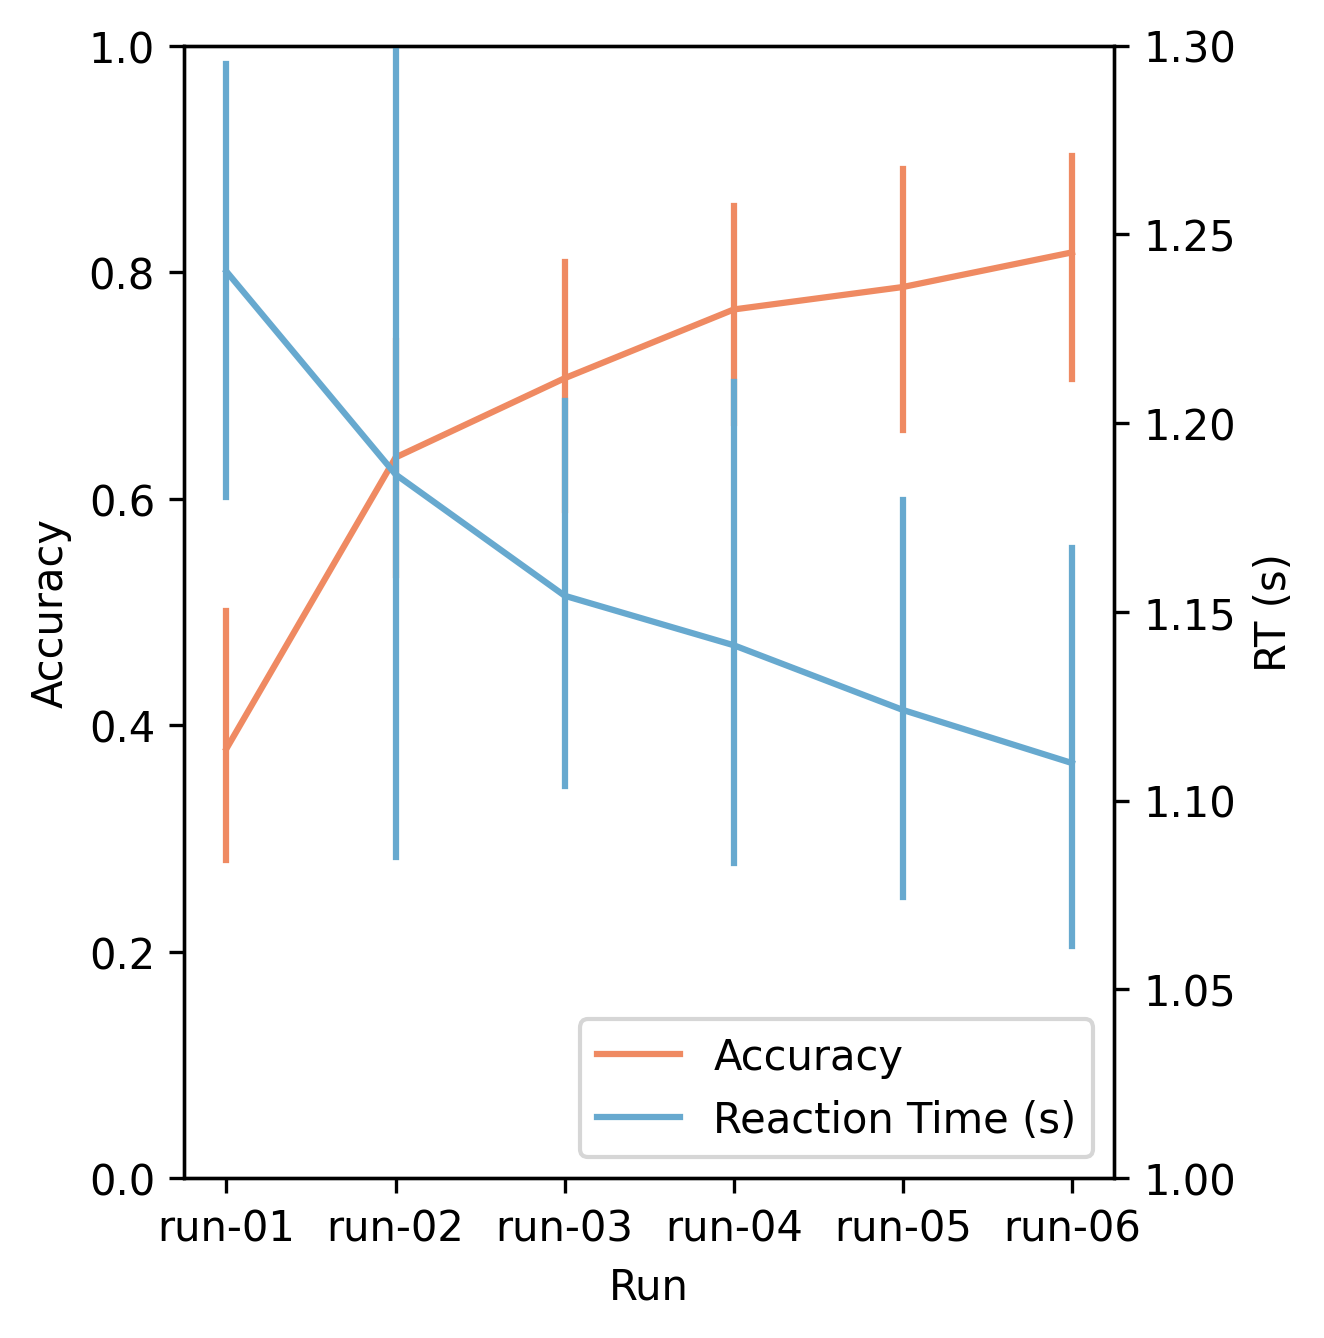

In [71]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4,5), dpi=300)
sns.lineplot(behav_df, x='Run', y='Accuracy', color='#ef8a62', err_style='bars', ax=ax)
ax.set_ylim([0, 1])
ax2 = ax.twinx()
sns.lineplot(behav_df, x='Run', y='RT (s)', color='#67a9cf', err_style='bars', ax=ax2)
ax2.set_ylim([1, 1.3])
ax.legend(loc="lower right",
          handles=[Line2D([], [], marker='_', color="#ef8a62", label='Accuracy'), 
                   Line2D([], [], marker='_', color="#67a9cf", label='Reaction Time (s)')])


#### Include individual lineplots

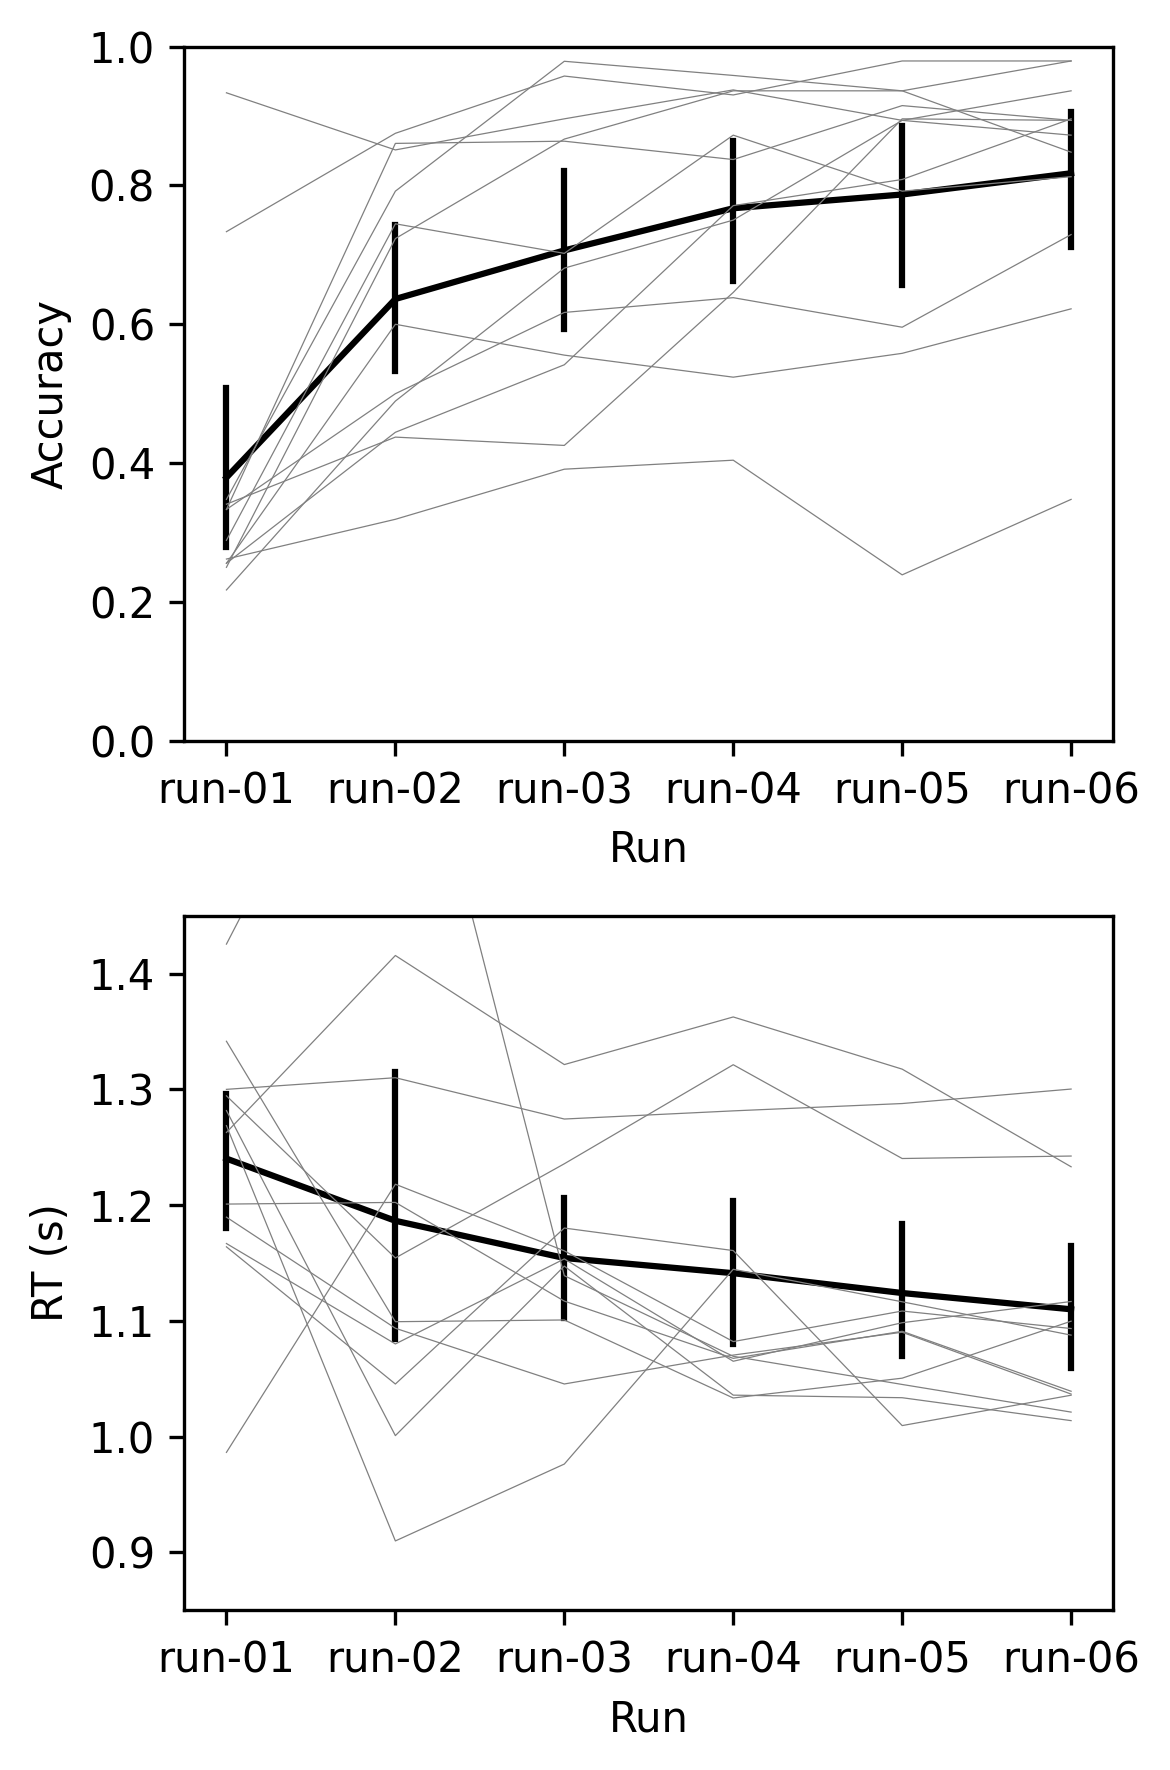

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), dpi=300)
sns.lineplot(behav_df, x='Run', y='Accuracy', 
             color='black', err_style='bars', 
             ax=ax[0])
sns.lineplot(behav_df, x='Run', y='Accuracy', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax[0],
             legend=None)
ax[0].set_ylim([0, 1])

sns.lineplot(behav_df, x='Run', y='RT (s)', 
             color='black', err_style='bars', 
             ax=ax[1])
sns.lineplot(behav_df, x='Run', y='RT (s)', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax[1],
             legend=None)
ax[1].set_ylim([0.85, 1.45])

fig.tight_layout()
#fig.savefig('behav_acc_rt.svg')

### Plot accuracy only

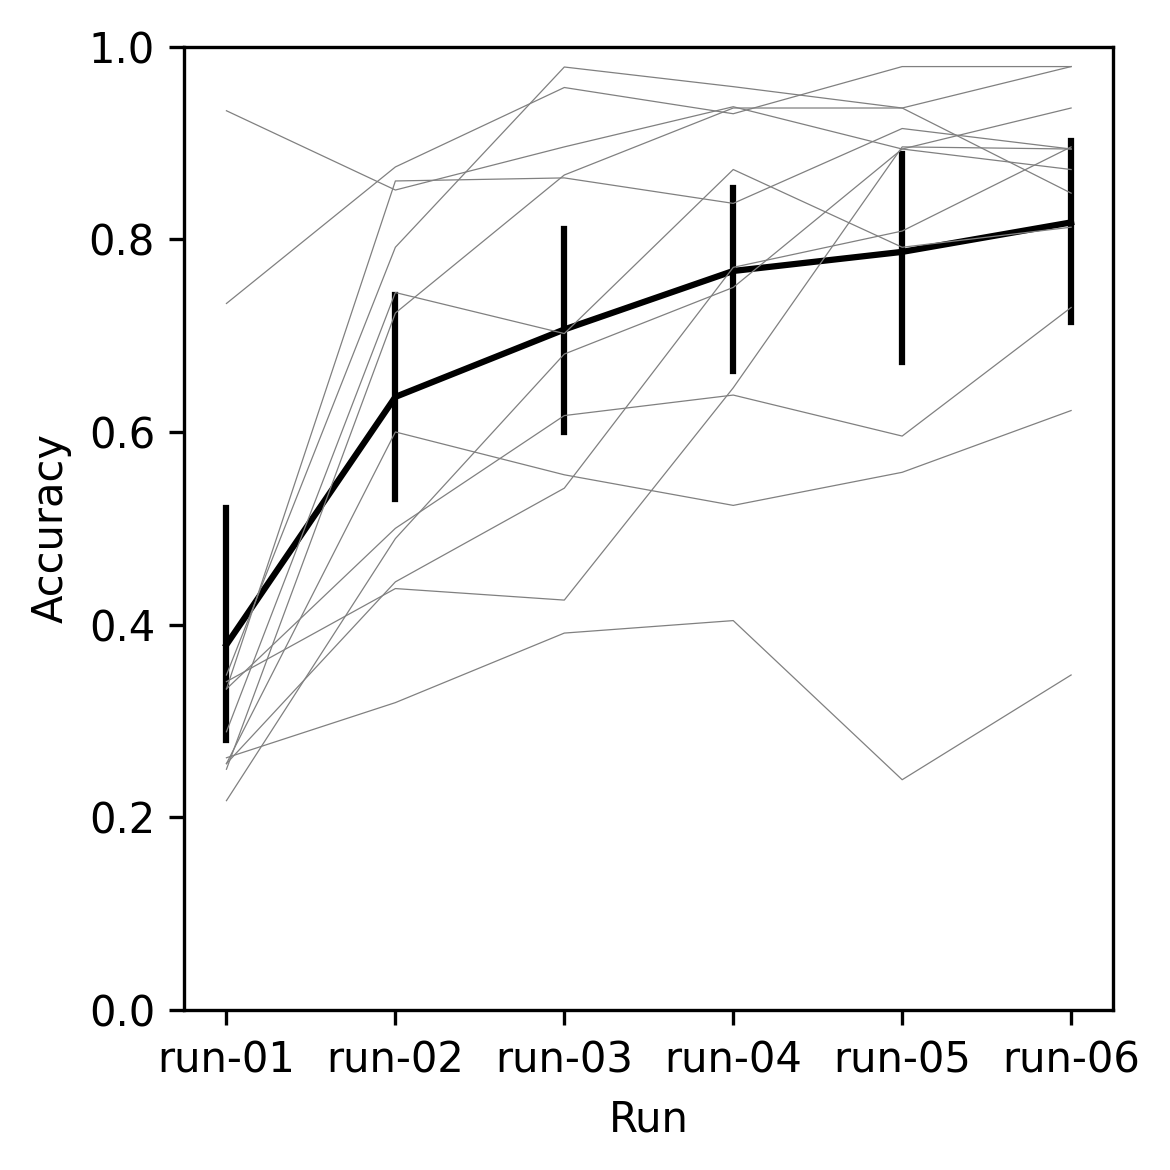

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)
sns.lineplot(behav_df, x='Run', y='Accuracy', 
             color='black', err_style='bars', 
             ax=ax)
sns.lineplot(behav_df, x='Run', y='Accuracy', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax,
             legend=None)
ax.set_ylim([0, 1])

fig.tight_layout()
fig.savefig('behav_acc-only.svg')

### t-statistics (run-wise)

In [11]:
data1 = behav_df.where(behav_df.Run=='run-01').dropna()['Accuracy']
data2 = behav_df.where(behav_df.Run=='run-06').dropna()['Accuracy']

res = stats.ttest_rel(data2, data1)
print('Accuracy')
print(f't = {res.statistic:.02f}; p = {res.pvalue:.04f}')

data1 = behav_df.where(behav_df.Run=='run-01').dropna()['RT (s)']
data2 = behav_df.where(behav_df.Run=='run-06').dropna()['RT (s)']

res = stats.ttest_rel(data2, data1)
print('RT (s)')
print(f't = {res.statistic:.02f}; p = {res.pvalue:.04f}')


Accuracy
t = 6.67; p = 0.0000
RT (s)
t = -3.29; p = 0.0072


# Response RDMs

In [22]:
resp_run_cm_dict = {}
for rx, run in enumerate(range(6)):
    group_cm_list = []
    for sub_id in sub_list_nman:
        bids_dir = os.path.join(bidsroot, sub_id, 'func')

        #bids_tsv_list = sorted(glob(bids_dir+f'/*task-{task_label}*events.tsv'))

        run_tsv = glob(bids_dir+f'/*task-{task_label}_run-0{rx+1}*events.tsv')[0]
        tsv_pd = pd.read_csv(run_tsv, sep='\t')

        tsv_pd = tsv_pd[~tsv_pd['trial_type'].str.contains('resp_None')]

        simple_df = tsv_pd.loc[:,['trial_type', 'correct_key']].dropna()
        simple_df = simple_df[~simple_df['trial_type'].str.contains('resp_8')]

        simple_df['correct_key'] = simple_df['correct_key'].astype(int).astype(str)

        simple_df['trial_type'] = [x[-1] for x in simple_df['trial_type']]

        renum_simple_df = simple_df.astype(str).replace(['7', '6', '1', '2'], 
                                                        ['1', '2', '3', '4'])

        cm = confusion_matrix(renum_simple_df['correct_key'], renum_simple_df['trial_type'], normalize='true')

        group_cm_list.append(cm)
    resp_run_cm_dict[f'run-0{rx+1}'] = group_cm_list

[Text(0, 0.5, 'T1'),
 Text(0, 1.5, 'T2'),
 Text(0, 2.5, 'T3'),
 Text(0, 3.5, 'T4')]

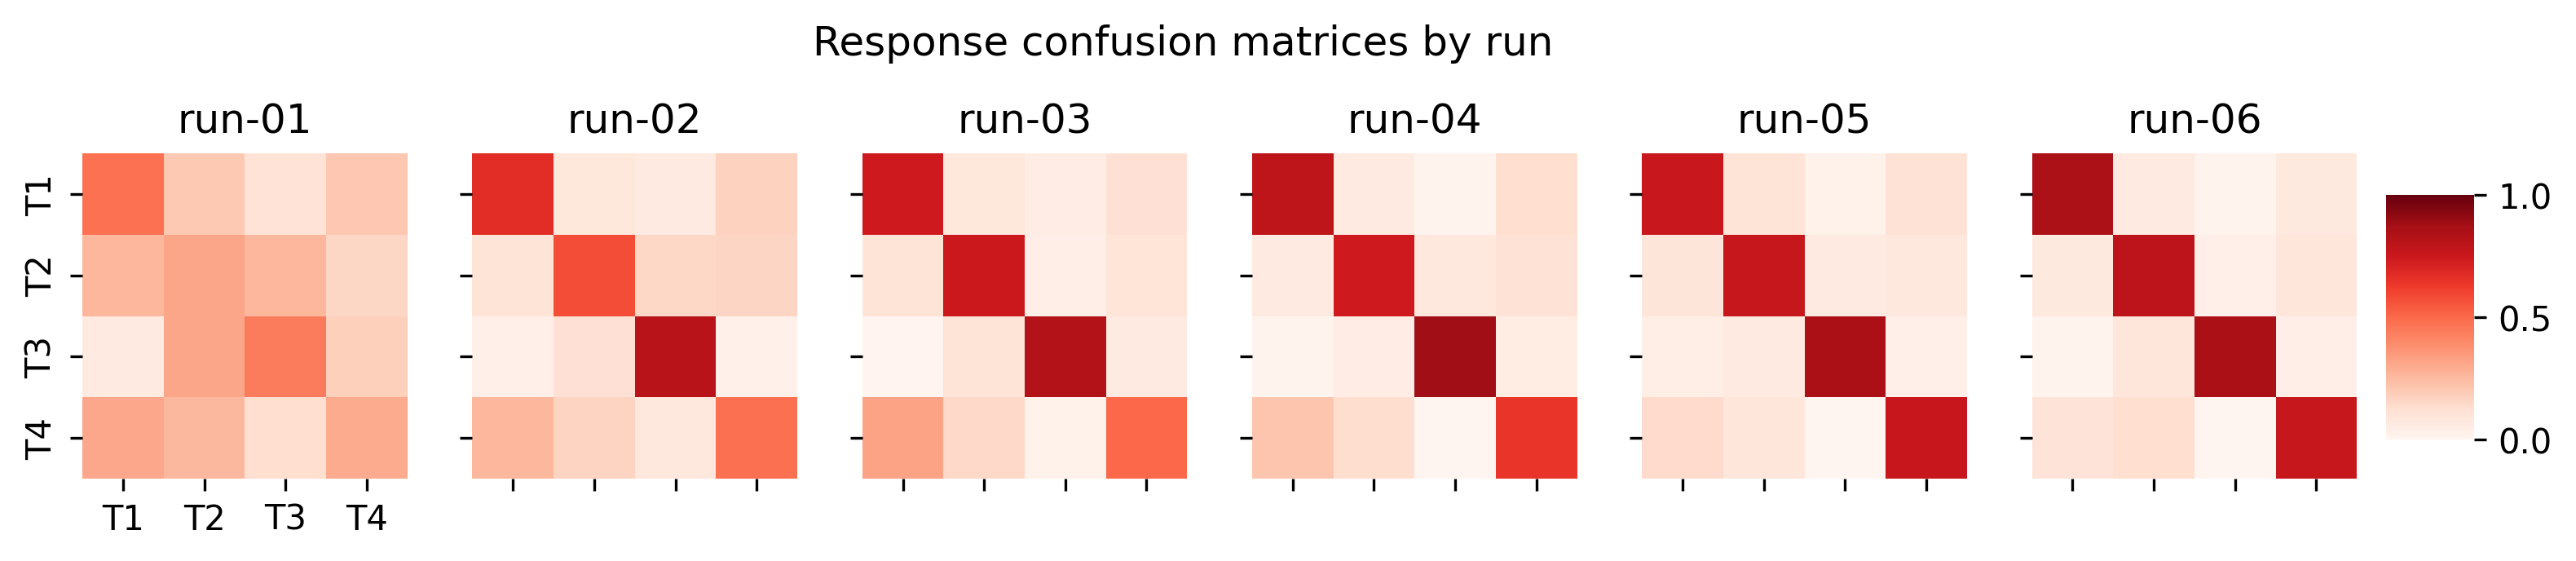

In [23]:
fig,ax = plt.subplots(1,6, figsize=(12,2.5), dpi=300, )#sharex=True, sharey=True)
fig.suptitle('Response confusion matrices by run')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for rx, run_id in enumerate(resp_run_cm_dict):
    #print(run_id)
    run_mean = np.mean(resp_run_cm_dict[run_id], axis=0)
    
    sns.heatmap(run_mean, 
                square=True,
                cmap='Reds',
                ax=ax[rx],
                cbar=True, cbar_ax=cbar_ax,
                annot=False,
                vmin=0, 
                vmax=1,
                xticklabels=['','','','',], # tone_labels, False,
                yticklabels=['','','','',], # tone_labels, False,
                ) 
    ax[rx].set_title(run_id)
    ax[rx].tick_params(labelsize=10)

ax[0].set_xticklabels(tone_labels)
ax[0].set_yticklabels(tone_labels)
#fig.tight_layout()
#fig.savefig('cm_response.svg')
#fig.savefig('cm_response_noticks.svg')

### Combine into learning stages

In [24]:
# Create a new dictionary to hold stage-level confusion matrices
resp_stage_cm_dict = {'early': [], 'middle': [], 'final': []}

# Aggregate matrices by stage
for run_id, cm_list in resp_run_cm_dict.items():
    stage = run_to_stage[run_id]
    resp_stage_cm_dict[stage].extend(cm_list)


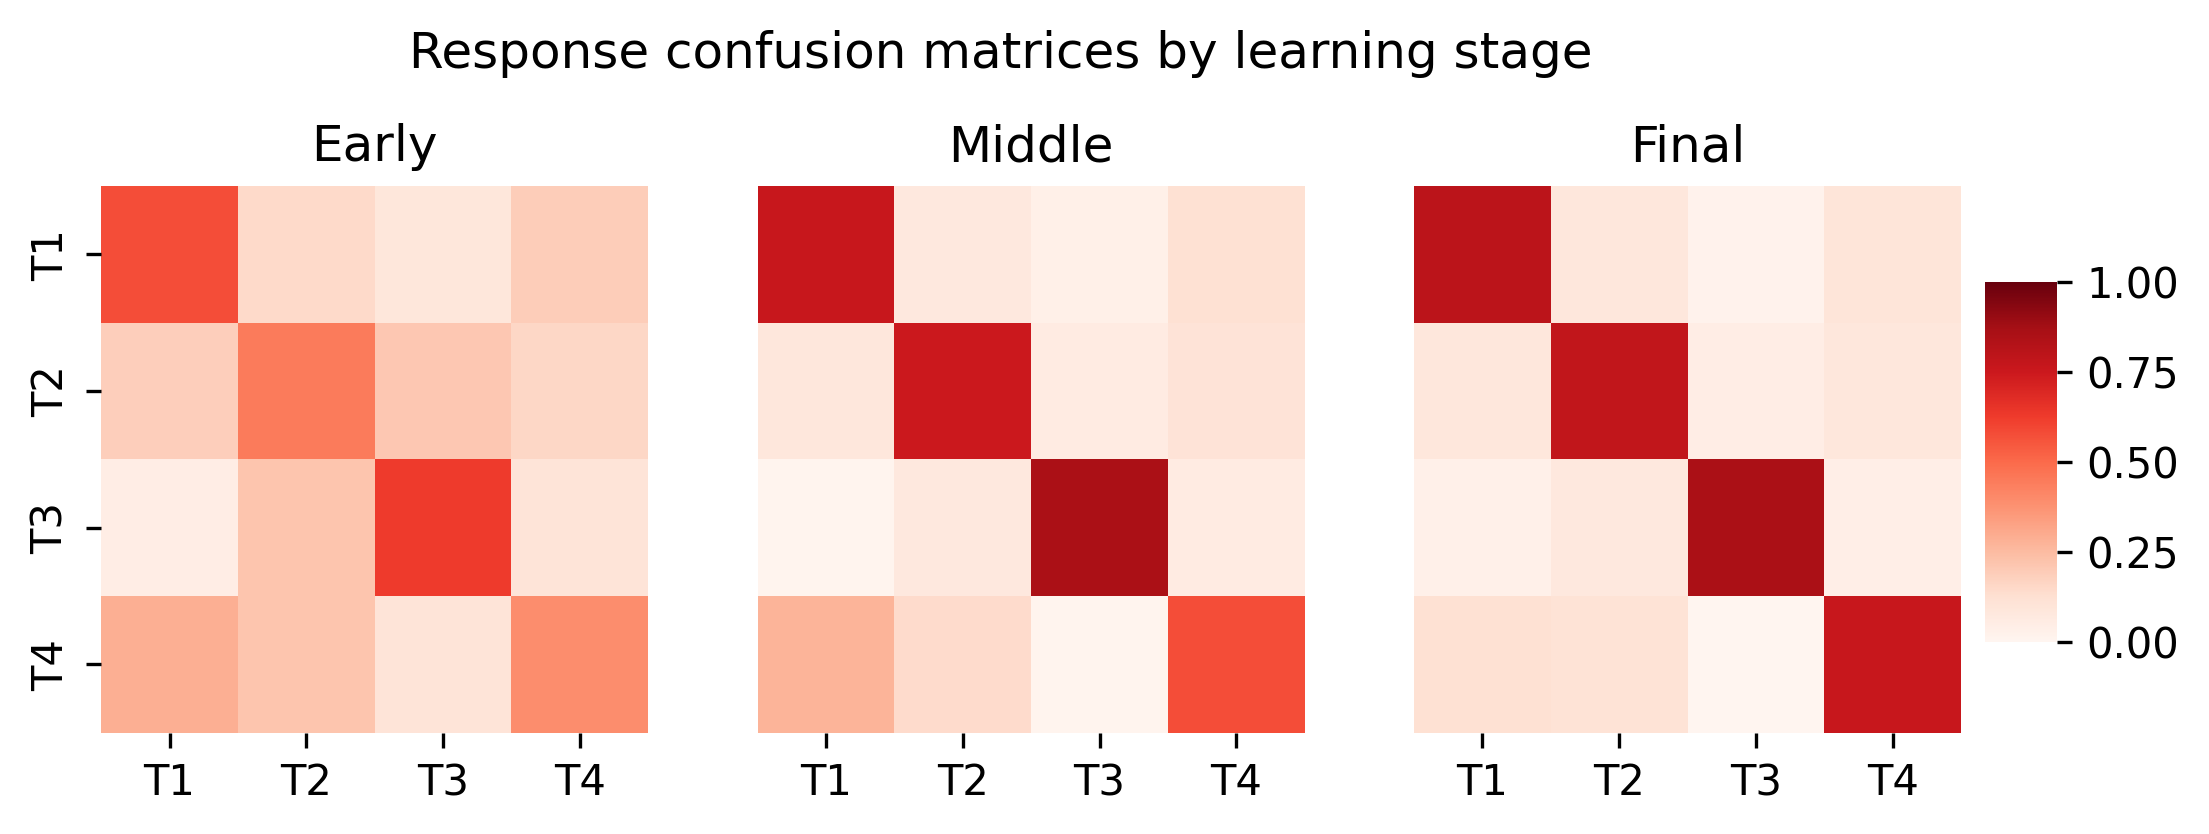

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
fig.suptitle('Response confusion matrices by learning stage')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, stage in enumerate(['early', 'middle', 'final']):
    stage_resp_mean = np.mean(resp_stage_cm_dict[stage], axis=0)
    
    sns.heatmap(stage_resp_mean,
                square=True,
                cmap='Reds',
                ax=ax[i],
                cbar=True if i == 2 else False,
                cbar_ax=cbar_ax if i == 2 else None,
                annot=False,
                vmin=0,
                vmax=1,
                xticklabels=tone_labels,
                yticklabels=tone_labels if i == 0 else False)
    
    ax[i].set_title(stage.capitalize())
    ax[i].tick_params(labelsize=10)
    
    if i > 0:
        ax[i].set_ylabel('')


#fig.savefig('cm_response_by_stage.svg')


# Behavioral RDMs

from Feng et al. (*NoL*):
> Learners’ response confusion matrices were created based on their categorization responses. If two sounds had an identical response, then this pair was coded as 0 in the confusion matrix; otherwise, it was coded as 1. Using this procedure, we created two confusion matrices in each block (one for each talker) for each learner. The two matrices were then averaged for each block. Finally, we calculated the Spearman’ s correlations (i.e., model fits) between each RDM and confusion matrices. We also examined the relationships between the RDM model fits and learning outcome and speed across subjects to see which RDM explains most of the interindividual variance in learning success.

**Only an example**--confusion matrices now created by `create_behav_confusion_matrices.py`

In [26]:
stim_df = tsv_pd.loc[:,['trial_type', 'correct_key']]

# create a `stimulus` row
stim_df['stimulus'] = ''

# copy stimulus info to the response rows
for ix in range(1, len(stim_df)):
    if 'resp' in stim_df['trial_type'][ix]:
        #stim_df['stimulus'].iloc[ix] = stim_df['trial_type'].iloc[ix-1].split('_')[1]
        stim_df.loc[ix, 'stimulus'] = stim_df['trial_type'].iloc[ix-1].split('_')[1]
        
# clean up the behavioral dataframe
stim_df.dropna(inplace=True)

# label the responses based on the feedback presented next
stim_df['trial_type'] = [x[-1] for x in stim_df['trial_type']]

# replace button press labels (from the MRI button boxes) with tone labels
stim_df['trial_type'] = stim_df['trial_type'].astype(str).replace(['7', '6', '1', '2'], 
                                                                  ['1', '2', '3', '4'])

stim_df['correct_key'] = stim_df['correct_key'].replace([7.0, 6.0, 1.0, 2.0], 
                                                        ['1', '2', '3', '4'])

In [27]:
stim_list = np.unique(stim_df[stim_df['stimulus'].str.contains('di')]['stimulus'])

# extract responses for each stimulus
all_stim_responses = []
for sx, stim in enumerate(stim_list):
    stim_responses = []
    for block in range(3):
        try:
            stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
        except:
            stim_responses.append(np.nan)
    all_stim_responses.append(stim_responses)

/scratch/slurm-7007573/ipykernel_3493173/3388081672.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
/scratch/slurm-7007573/ipykernel_3493173/3388081672.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
/scratch/slurm-7007573/ipykernel_3493173/3388081672.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
/scratch/slurm-7007573/ipykernel_3493173/3388081672.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stim_responses.append(stim_df.loc[48*(block):48*(block+1)][stim_df['stimulus']==stim]['trial_type'].array[0])
/scratch/slurm-7

In [28]:
# compare responses across stimuli
n_stim = len(all_stim_responses)
stim_conf_mat = np.zeros((n_stim, n_stim))
for srx in range(n_stim):
    for sry in range(n_stim):
        mean_val = np.mean([int(all_stim_responses[srx][x] == all_stim_responses[sry][x]) for x in range(3)])
        stim_conf_mat[srx, sry] = mean_val

# save output matrix
sub_beh_out_dir = os.path.join(beh_out_dir, sub_id)
os.makedirs(sub_beh_out_dir, exist_ok=True)
sub_run_out_fpath = os.path.join(sub_beh_out_dir, 
                                 f'{sub_id}_{run_id}_stimulus_confusion_matrix.tsv')
#np.savetxt(sub_run_out_fpath, stim_conf_mat, delimiter='\t')

# Group analyses

After generating single-subject, single-run confusion matrices via `create_behav_confusion_matrices.py`

In [29]:
stim_labels = ['di1_aN', 'di1_bN', 'di1_hN', 'di1_iN', 
               'di2_aN', 'di2_bN', 'di2_hN', 'di2_iN', 
               'di3_aN', 'di3_bN', 'di3_hN', 'di3_iN', 
               'di4_aN', 'di4_bN', 'di4_hN', 'di4_iN', ]

In [30]:
stim_run_cm_dict = {}
for rx, run in enumerate(range(6)):
    run_cm_list = []
    for smx, sub_id in enumerate(sub_list_nman):
        sub_beh_dir = os.path.join(deriv_dir, 'behavior', sub_id)
        sub_stim_cm_list = []

        sub_run_stim_cm = np.genfromtxt(os.path.join(sub_beh_dir, f'{sub_id}_run-0{rx+1}_stimulus_confusion_matrix.tsv'))
        run_cm_list.append(sub_run_stim_cm)
    stim_run_cm_dict[f'run-0{run+1}'] = run_cm_list

Text(433.3333333333333, 0.5, 'stimulus')

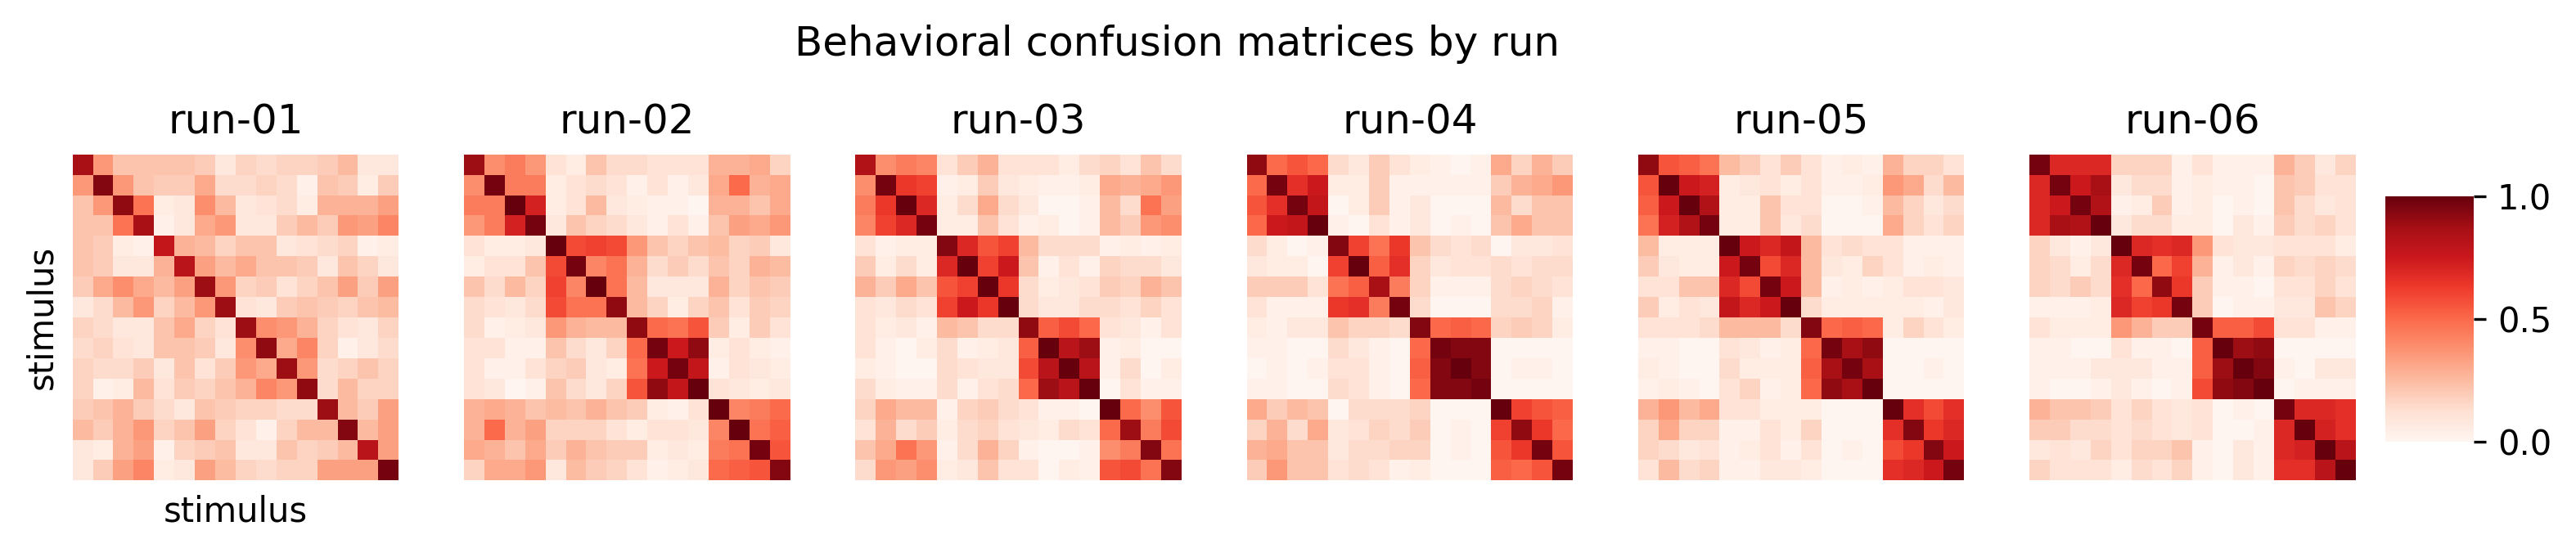

In [143]:
fig,ax = plt.subplots(1,6, figsize=(12,2.5), dpi=300, sharey=True)
fig.suptitle('Behavioral confusion matrices by run')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for rx, run_id in enumerate(stim_run_cm_dict):
    #print(run_id)
    run_mean = np.mean(stim_run_cm_dict[run_id], axis=0)
    
    sns.heatmap(run_mean, 
                square=True,
                cmap='Reds',
                vmin=0, vmax=1,
                ax=ax[rx],
                cbar=True, cbar_ax = cbar_ax,
                xticklabels=False, #stim_labels,
                yticklabels=False, #stim_labels,
                ) 
    ax[rx].set_title(run_id)
    ax[rx].tick_params(labelsize=6)
    #ax[rx].set_xticklabels(ax[rx].get_xticklabels(), rotation=60, ha='right');

ax[0].set_xlabel('stimulus')
ax[0].set_ylabel('stimulus')
#fig.tight_layout()
#fig.savefig('cm_behavior_noticks_v2.svg')

In [31]:
# Create a new dictionary to hold stage-level confusion matrices
stim_stage_cm_dict = {'early': [], 'middle': [], 'final': []}

# Aggregate matrices by stage
for run_id, cm_list in stim_run_cm_dict.items():
    stage = run_to_stage[run_id]
    stim_stage_cm_dict[stage].extend(cm_list)


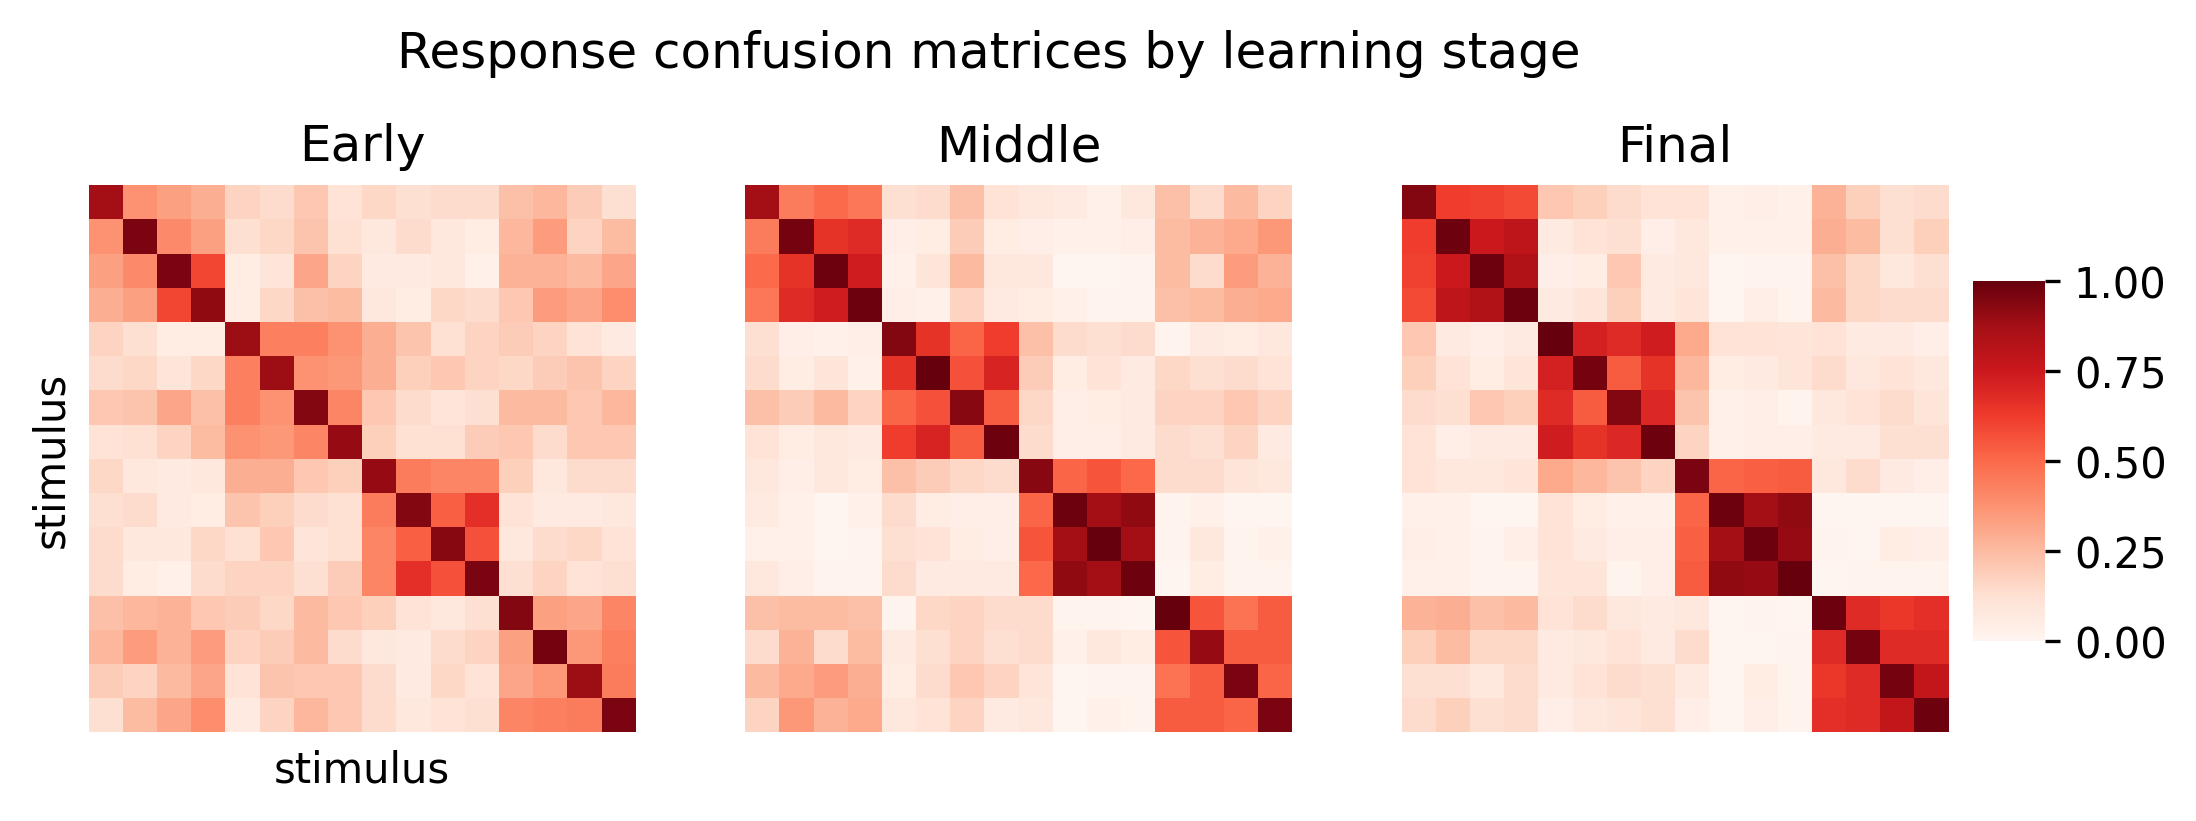

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
fig.suptitle('Response confusion matrices by learning stage')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, stage in enumerate(['early', 'middle', 'final']):
    stage_mean = np.mean(stim_stage_cm_dict[stage], axis=0)
    
    sns.heatmap(stage_mean,
                square=True,
                cmap='Reds',
                ax=ax[i],
                cbar=True if i == 2 else False,
                cbar_ax=cbar_ax if i == 2 else None,
                annot=False,
                vmin=0,
                vmax=1,
                xticklabels=False, #stim_labels,
                yticklabels=False, #stim_labels,
               )
    
    ax[i].set_title(stage.capitalize())
    ax[i].tick_params(labelsize=10)
    
    ax[0].set_xlabel('stimulus')
    ax[0].set_ylabel('stimulus')
    
    if i > 0:
        ax[i].set_ylabel('')


#fig.savefig('cm_response_by_stage.svg')


# Combine plots

/scratch/slurm-7007573/ipykernel_3493173/4183542676.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dict['accuracy'].set_xticklabels(['Early', 'Middle', 'Final'])


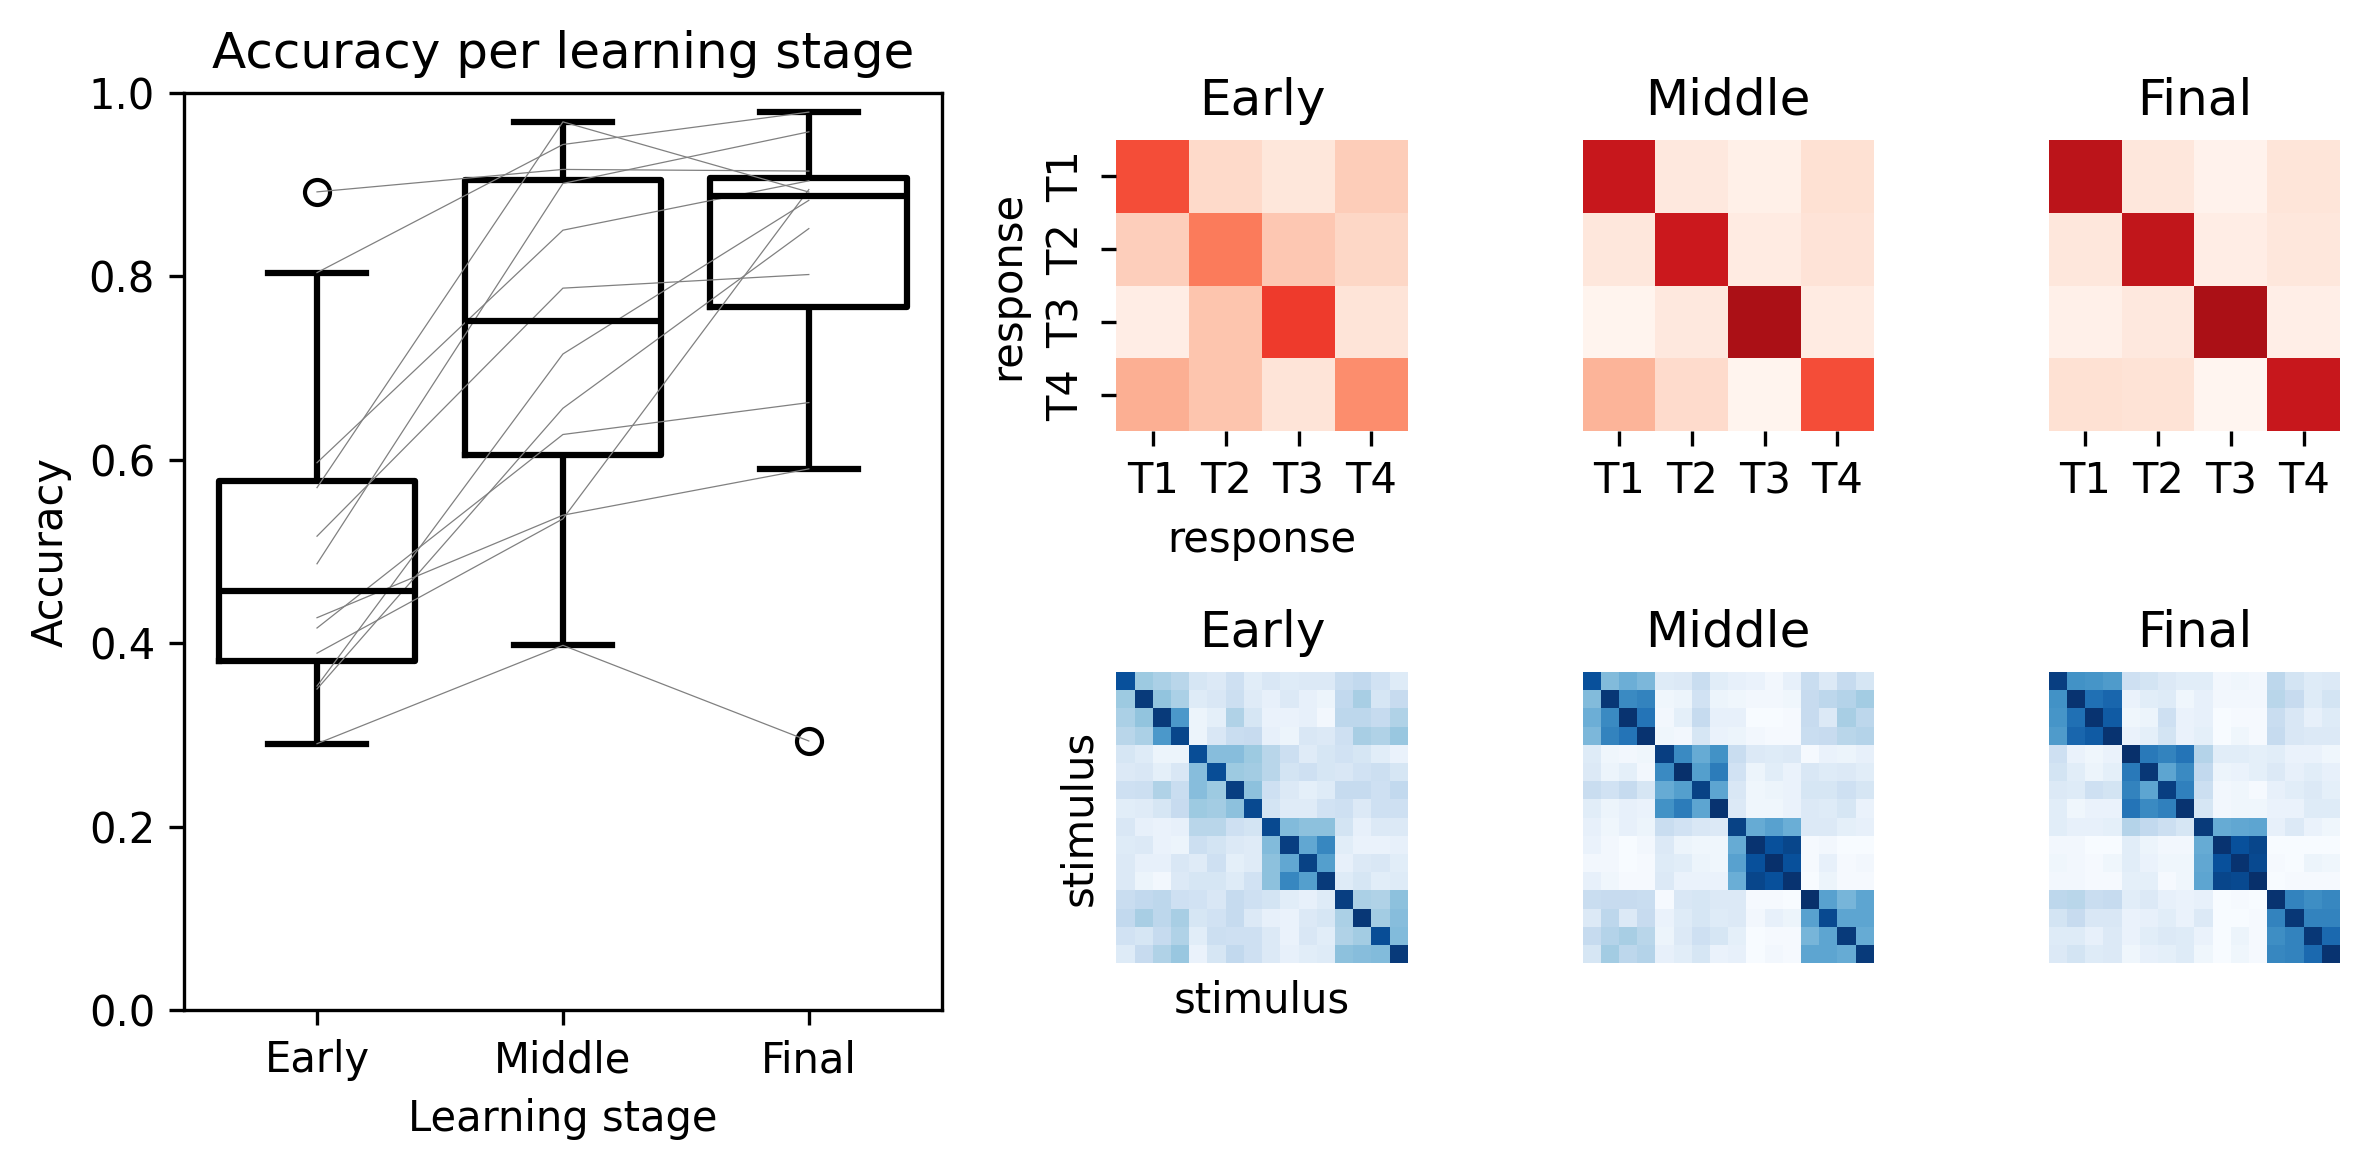

In [34]:
layout = [
    ['accuracy', 'accuracy', 'response_early', 'response_middle', 'response_final'],
    ['accuracy', 'accuracy', 'stimulus_early', 'stimulus_middle', 'stimulus_final'],
]

fig, ax_dict = plt.subplot_mosaic(layout, figsize=(8, 4), dpi=300)

# Accuracy boxplot
sns.boxplot(stage_df, x='Learning_Stage', y='Accuracy', 
            color='k', fill=False,
            ax=ax_dict['accuracy'])
sns.lineplot(stage_df, x='Learning_Stage', y='Accuracy', 
             hue='Participant_ID', 
             palette=sns.color_palette(['grey'], 12),
             linewidth=0.3,
             ax=ax_dict['accuracy'],
             legend=None)
ax_dict['accuracy'].set_ylim([0, 1])
ax_dict['accuracy'].set_xlabel('Learning stage')
ax_dict['accuracy'].set_xticklabels(['Early', 'Middle', 'Final'])
ax_dict['accuracy'].set_title('Accuracy per learning stage')

# Response confusion matrices
for i, stage in enumerate(['early', 'middle', 'final']):
    cm = np.mean(resp_stage_cm_dict[stage], axis=0)
    sns.heatmap(cm, square=True, cmap='Reds',
                ax=ax_dict[f'response_{stage}'],
                cbar=False,
                annot=False,
                vmin=0,
                vmax=1,
                xticklabels=tone_labels,
                yticklabels=tone_labels if i == 0 else False)
    ax_dict[f'response_{stage}'].set_title(f'{stage.capitalize()}')

ax_dict[f'response_early'].set_xlabel('response')
ax_dict[f'response_early'].set_ylabel('response')

# Stimulus confusion matrices
for stage in ['early', 'middle', 'final']:
    cm = np.mean(stim_stage_cm_dict[stage], axis=0)
    sns.heatmap(cm, square=True, cmap='Blues',
                ax=ax_dict[f'stimulus_{stage}'],
                cbar=False, annot=False, vmin=0, vmax=1,
                xticklabels=False, yticklabels=False)
    ax_dict[f'stimulus_{stage}'].set_title(f'{stage.capitalize()}')

ax_dict[f'stimulus_early'].set_xlabel('stimulus')
ax_dict[f'stimulus_early'].set_ylabel('stimulus')
    
fig.tight_layout()
fig.savefig('behav_learning-stage.svg')

# ARCHIVE

## Mandarin speaking participants

In [14]:
run_cm_dict = {}
for rx, run in enumerate(range(6)):
    run_cm_list = []
    for smx, sub_id in enumerate(sub_list_mand):
        sub_beh_dir = os.path.join(deriv_dir, 'behavior', sub_id)
        sub_stim_cm_list = []

        sub_run_stim_cm = np.genfromtxt(os.path.join(sub_beh_dir, f'{sub_id}_run-0{rx+1}_stimulus_confusion_matrix.tsv'))
        run_cm_list.append(sub_run_stim_cm)
    run_cm_dict[f'run0{run+1}'] = run_cm_list

In [15]:
stim_labels = ['di1_aN', 'di1_bN', 'di1_hN', 'di1_iN', 
               'di2_aN', 'di2_bN', 'di2_hN', 'di2_iN', 
               'di3_aN', 'di3_bN', 'di3_hN', 'di3_iN', 
               'di4_aN', 'di4_bN', 'di4_hN', 'di4_iN', ]

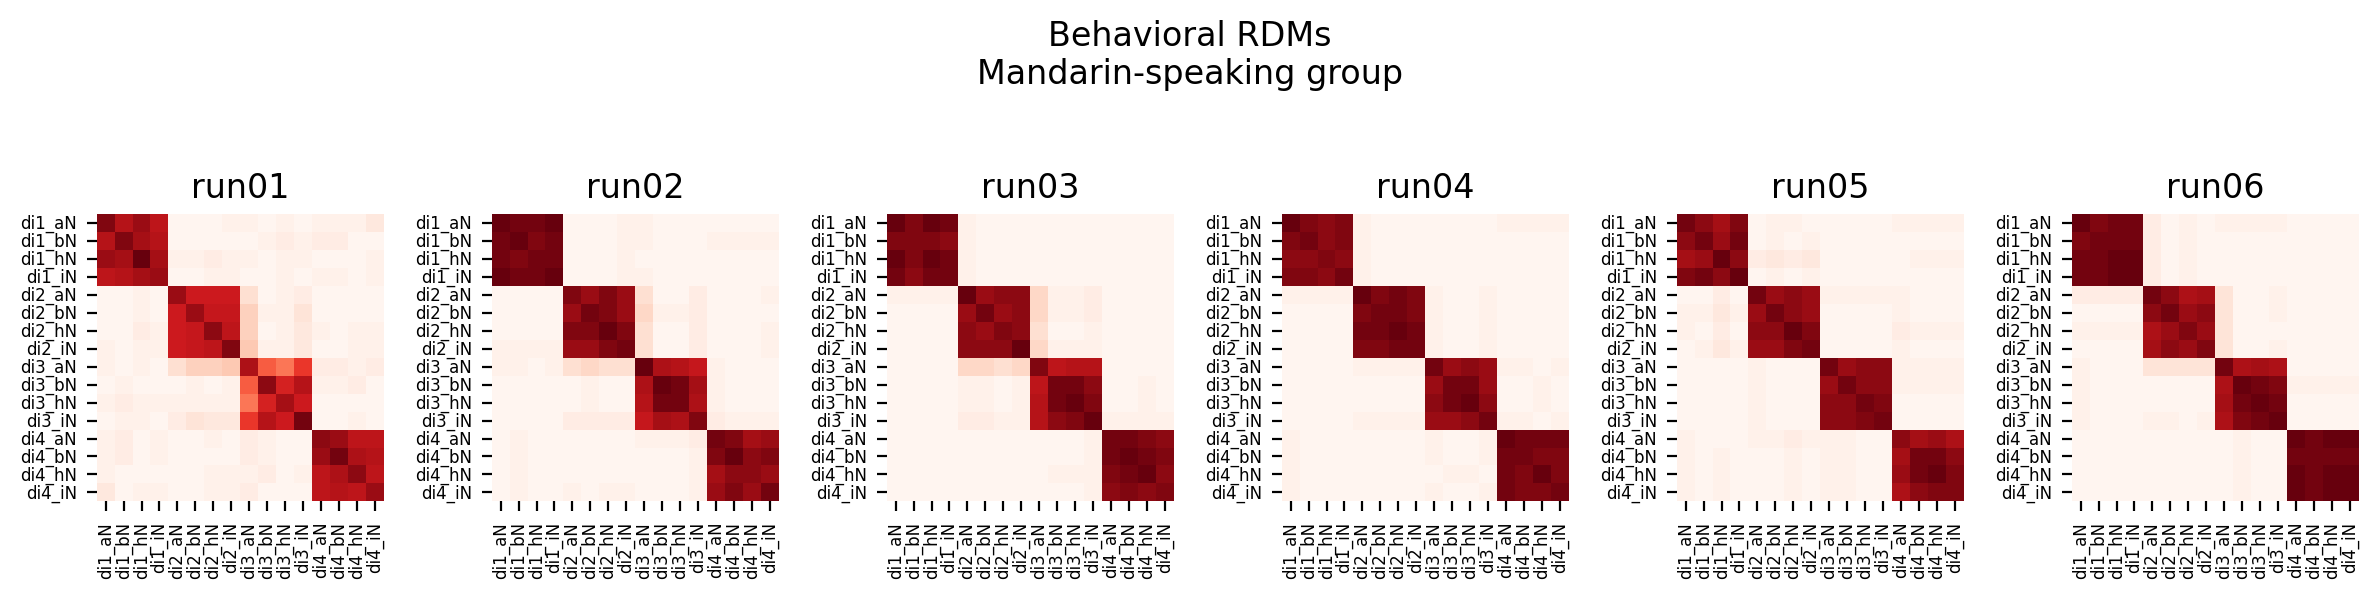

In [16]:
fig,ax = plt.subplots(1,6, figsize=(12,3), dpi=200)
fig.suptitle('Behavioral RDMs\nMandarin-speaking group')

for rx, run_id in enumerate(run_cm_dict):
    #print(run_id)
    run_mean = np.mean(run_cm_dict[run_id], axis=0)
    
    sns.heatmap(run_mean, 
                square=True,
                cmap='Reds',
                ax=ax[rx],
                cbar=False,
                xticklabels=stim_labels,
                yticklabels=stim_labels,
                ) 
    ax[rx].set_title(run_id)
    ax[rx].tick_params(labelsize=6)

fig.tight_layout()